In [9]:
#pip install pylidc

In [2]:
import pylidc as pl
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Query for all CT scans with desired traits.
scans = pl.query(pl.Scan).filter(pl.Scan.slice_thickness <= 1, pl.Scan.pixel_spacing <= 0.6)
print(scans.count())
# => 31

pid = 'LIDC-IDRI-0078'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
print(scan)

31
Scan(id=1,patient_id=LIDC-IDRI-0078)


In [12]:
print(type(pl.Scan.slice_thickness))
# => <class 'sqlalchemy.orm.attributes.InstrumentedAttribute'>
# => ^^^ queryable because it's an sqlalchemy attribute.

# Whereas ...
print(type(pl.Scan.slice_spacing))
# => <type 'property'>
# ^^^ not queryable because it's a computed property

<class 'sqlalchemy.orm.attributes.InstrumentedAttribute'>
<class 'property'>


In [13]:
print(len(scan.annotations))
# => 13

13


In [14]:
nods = scan.cluster_annotations()

print("%s has %d nodules." % (scan, len(nods)))
# => Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))

Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.


In [15]:
vol = scan.to_volume()
print(vol.shape)
# => (512, 512, 87)

print("%.2f, %.2f" % (vol.mean(), vol.std()))
# => -702.15, 812.52

Loading dicom files ... This may take a moment.
(512, 512, 87)
-702.15, 812.52


Loading dicom files ... This may take a moment.


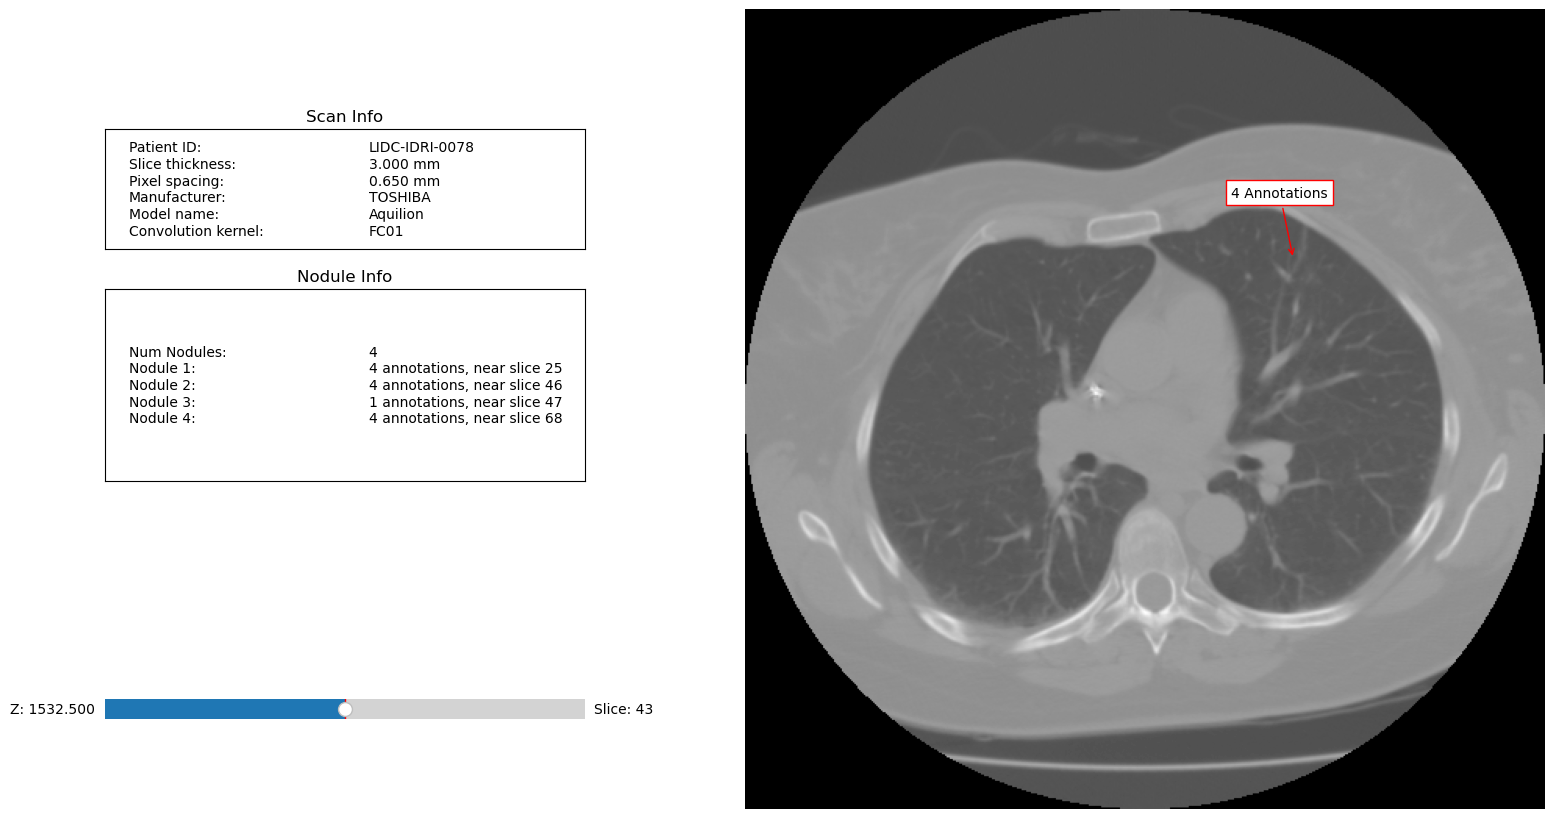

In [16]:
scan.visualize(annotation_groups=nods)

### Annotation Visualization

Loading dicom files ... This may take a moment.


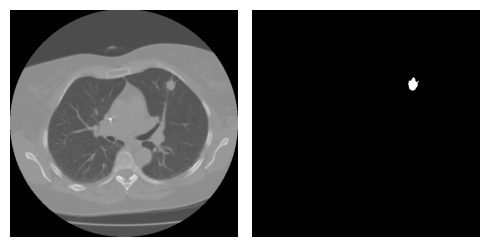

In [17]:

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()

# original size 512x512
padding = [(512,512), (512,512), (0,0)]

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

### CT Visualization

Loading dicom files ... This may take a moment.


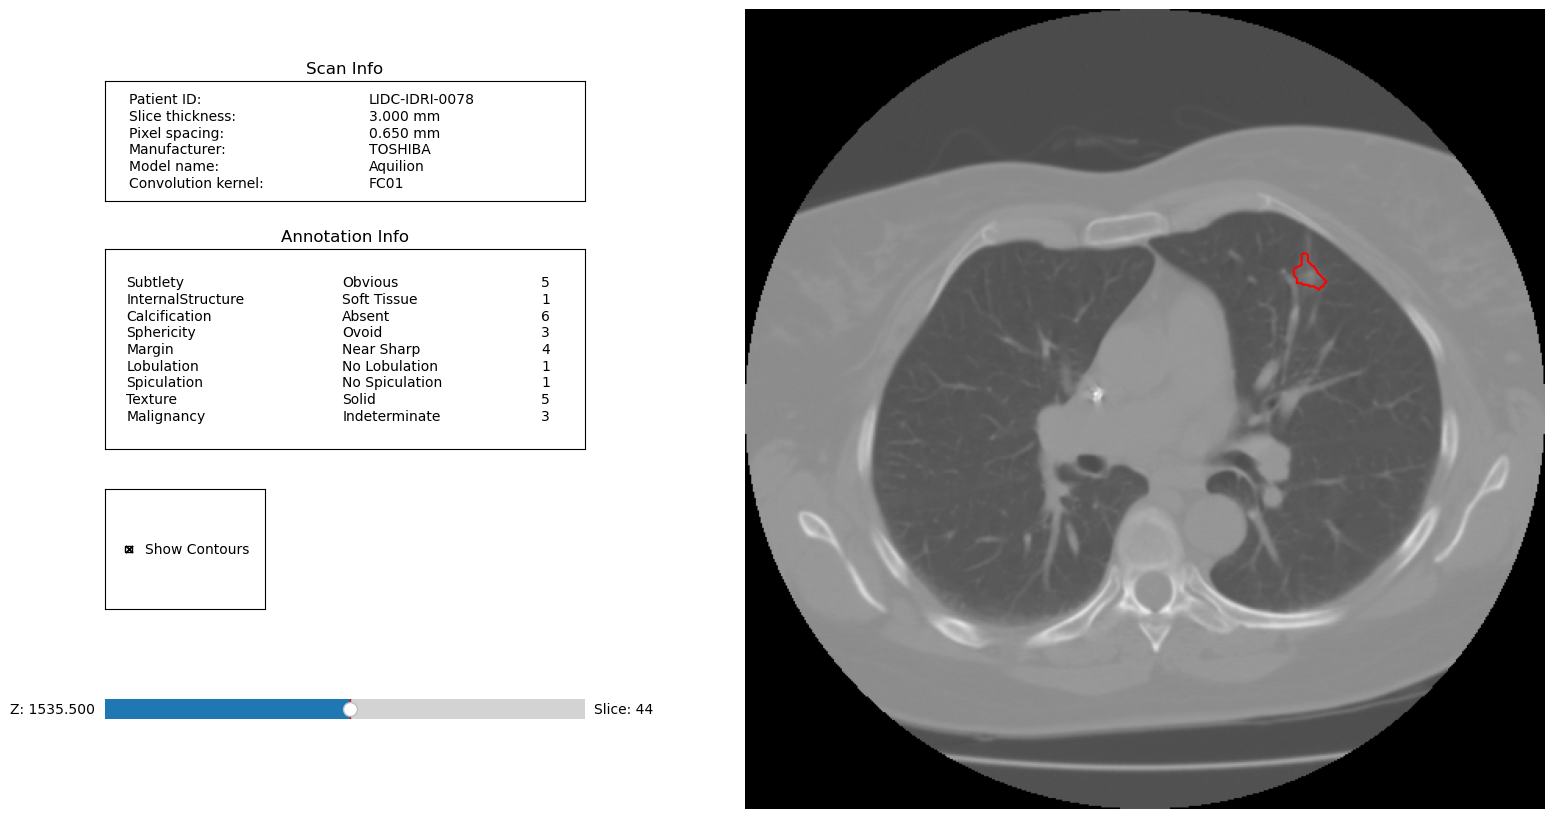

In [18]:
ann = pl.query(pl.Annotation).first()
ann.visualize_in_scan()

## Data Characteristis

In [19]:
# Characteristis for the module
print(pl.annotation_feature_names)

('subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy')


In [20]:
# prints the first annotation with pl.Annotation.malignancy == 5
ann = pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).first()

print(ann.malignancy, ann.Malignancy)
# => 5, 'Highly Suspicious'

print(ann.margin, ann.Margin)
# => 2, 'Near Poorly Defined'

5 Highly Suspicious
2 Near Poorly Defined


In [21]:
# prints all the fearue well formated
ann.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 


In [22]:
# print specific features from the annotations
svals = pl.query(pl.Annotation.spiculation).filter(pl.Annotation.spiculation > 3)

print(svals[0])
# => (4,)

print(all([s[0] > 3 for s in svals]))
# => True

(4,)
True


## Contour-derived data

In [23]:
ann = pl.query(pl.Annotation).first()
contours = ann.contours

print(contours[0])

Contour(id=1,annotation_id=1)


In [24]:
# print the dimentions of the nodule
print("%.2f mm, %.2f mm^2, %.2f mm^3" % (ann.diameter, ann.surface_area, ann.volume))

20.84 mm, 1124.13 mm^2, 2439.30 mm^3


In [25]:
# A boolean-valued volume can be obtained that is 1 to indicate nodule and 0 to indicate non-nodule
mask = ann.boolean_mask()
print(mask.shape, mask.dtype)

(34, 27, 6) bool


In [26]:
# Dimentions of the binding box 
print(ann.bbox_dims())

[21.45 16.9  15.  ]


### Surface Visulization

In [31]:
'''ann = pl.query(pl.Annotation).filter(pl.Annotation.lobulation == 5).first()
ann0 = ann[0]
ann0.visualize_in_3d()'''

AttributeError: module 'matplotlib.cm' has no attribute 'cmap_d'

#### What to include in the data:

Characteristics, surface area, diameter, volume, imagem (boolena + boxing filter), coords (centroid), diagnosys (target), 

Loading dicom files ... This may take a moment.


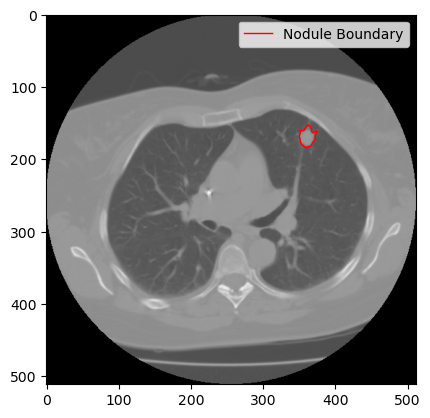

centroid: (167, 361) 


In [ ]:
ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")
plt.legend()
plt.show()


# find the centroid of the nodule
m = con.to_matrix(include_k=False)
#print(m)

x = int(m[:, 0].mean())
y = int(m[:, 1].mean())
print(f"centroid: ({x}, {y}) ")